In [1]:
import argparse
import os
import ruamel_yaml as yaml
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.distributed as dist

from src.pre_vqa import PreVQA
from src.vision_transformer import interpolate_pos_embed
from src.tokenization_bert import BertTokenizer

import utils
from dataset.utils import save_result
from dataset import create_dataset, create_sampler, create_loader, vqa_collate_fn

from scheduler import create_scheduler
from optim import create_optimizer

In [2]:
config = yaml.load(open('./configs/vqa.yaml', 'r'), Loader=yaml.Loader)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = PreVQA(config=config, text_encoder='bert-base-uncased', text_decoder='bert-base-uncased', tokenizer=tokenizer)
 

In [3]:
device = 'cpu'
img_root=config['vqa_root']
model=model.to(device)
model.eval()

PreVQA(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate=none)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      

In [4]:
checkpoint = torch.load('output/vqa/checkpoint_00.pth', map_location='cpu') 
state_dict = checkpoint['model']
model.load_state_dict(state_dict,strict=False)

<All keys matched successfully>

In [5]:
# print(model.text_encoder.encoder.layer[8].crossattention.self)
model.text_encoder.encoder.layer[8].crossattention.self.save_attention = True

In [5]:
from PIL import Image
from torchvision import transforms
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
test_transform = transforms.Compose([
        transforms.Resize((config['image_res'],config['image_res']),interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        normalize,
        ]) 

/home/xinghao/anaconda3/envs/xinghao/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


['net', 'pitcher', 'orange', 'yes', 'white', 'skiing', 'red', 'frisbee', 'brushing teeth', 'no', 'black and white', 'skateboard', '1', 'blue', 'green', 'motorcycle', 'gray', '2', 'purse', 'skis', 'poles', 'surfboard', 'dog', 'on', 'office', 'large', 'very big', 'laptop', 'vent', 'computer', 'black', 'bear', '3', 'wii', 'glasses', 'tree', 'eating', 'log', '5', 'raft', 'left', 'living room', 'pink', 'right', 'railing', 'grass', 'wire', '10 years', 'knife', 'cake', 'banana', 'chef', 'vanilla', '4', 'outdoor', 'mustard', 'bun', 'clouds', 'dock', 'brown', 'silver', 'refrigerator', 'square', 'teddy', 'elm', 'stripes', 'baseball', 'catcher', 'beer', 'bottom', 'north', 'nike', 'yellow and white', 'morning', 'elephant', 'red and white', 'propeller', 'tan', 'wall', 'rolex', 'clock', 'table', '0', 'wood', 'christmas', 'spinach', 'thick', 'bag', 'leaves', 'necklace', '6', 'bathroom', 'shower', 'towel', 'solid', 'referee', 'wilson', '8:00', 'e', '24', 'hat', 'grazing', 'sheep', '10', 'tag', 'spanis

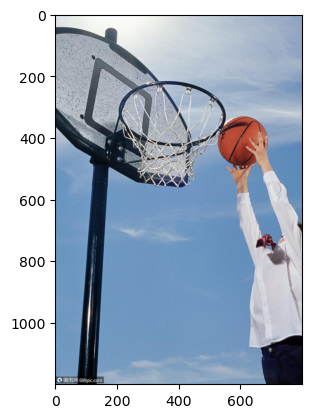

In [6]:
import requests
import matplotlib.pyplot as plt
question =  "how many basketball are there"
image_url = "https://img2.baidu.com/it/u=877247869,2844602241&fm=253&fmt=auto&app=120&f=JPEG?w=800&h=1200"
answer_list = json.load(open(config['answer_list'],'r'))  
print(answer_list)
answer_list = [answer+config['eos'] for answer in answer_list]
print(answer_list)
answer_input = tokenizer(answer_list, padding='longest', return_tensors='pt').to(device) 
row_image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')   
plt.imshow(row_image)
plt.show()
image = test_transform(row_image) 

image = torch.unsqueeze(image,0)
image = image.to(device,non_blocking=True) 
question_input = tokenizer(question, padding='longest', return_tensors="pt").to(device)


In [134]:
hook_handlers = []
attentions = []
def get_attention_weights0(module,input,output):
    global attentions 
    attentions = input
    print(input[3].size())
hook_handlers.append(model.text_encoder.encoder.layer[8].crossattention.self.register_forward_hook(get_attention_weights0))

In [39]:
hook_handlers[0].remove()
# model.text_encoder.base_model.base_model.encoder.layer[8].crossattention.self.save_attention = True


In [7]:
# topk_ids, topk_probs = model(image, question_input, answer_input, train=False, k=config['k_test'])
model.zero_grad()
loss, logits = model(image, question_input, answer_input, train=False, k=config['k_test'])
print(logits[0][0][3455])
# Q[1,6,768] KV[1,577,768] -> [1,6,12,64] [1,577,12,64]
# soft(Q*k/DIM) [1,12,6,577]


tensor(-1.0027, grad_fn=<SelectBackward0>)


In [9]:
print(logits.argmax(-1))
print(tokenizer.convert_ids_to_tokens(1015))

tensor([[1015]])
1


In [185]:
from torch.nn import CrossEntropyLoss,Softmax
import torch.nn.functional as F
attns = model.text_encoder.encoder.layer[8].crossattention.self.get_attn_gradients()
grads = model.text_encoder.encoder.layer[8].crossattention.self.get_attention_map()
print(model.text_encoder.encoder.layer[8].crossattention.self.get_attention_map().size())
loss_fc = CrossEntropyLoss()
labels = F.one_hot(torch.tensor(2748),30522).to(torch.float32)

# print(pre.size())
loss1 = loss_fc(logits[0,0,:],labels)


print(loss1)
loss1.backward()



torch.Size([1, 12, 5, 577])
tensor(0.0440, grad_fn=<DivBackward1>)


In [186]:
mask = question_input.attention_mask
print(mask.size())
mask = mask.view(mask.size(0),1,-1,1,1)
print(mask.size())
print(attns[:,:,:,1:].size())
cams = attns[:,:,:,1:].reshape(image.size(0),12,-1,24,24)*mask
print(cams.size())
gradcam = grads[:,:,:,1:].clamp(0).reshape(image.size(0),12,-1,24,24)*mask
gradcam = gradcam * cams
gradcam = gradcam[0].mean(0).cpu().detach().numpy()



torch.Size([1, 5])
torch.Size([1, 1, 5, 1, 1])
torch.Size([1, 12, 5, 576])
torch.Size([1, 12, 5, 24, 24])


In [187]:
from skimage import transform as skimage_transform
from scipy.ndimage import filters
import cv2 
def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.7).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap

float32


/tmp/ipykernel_1296675/487968824.py:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


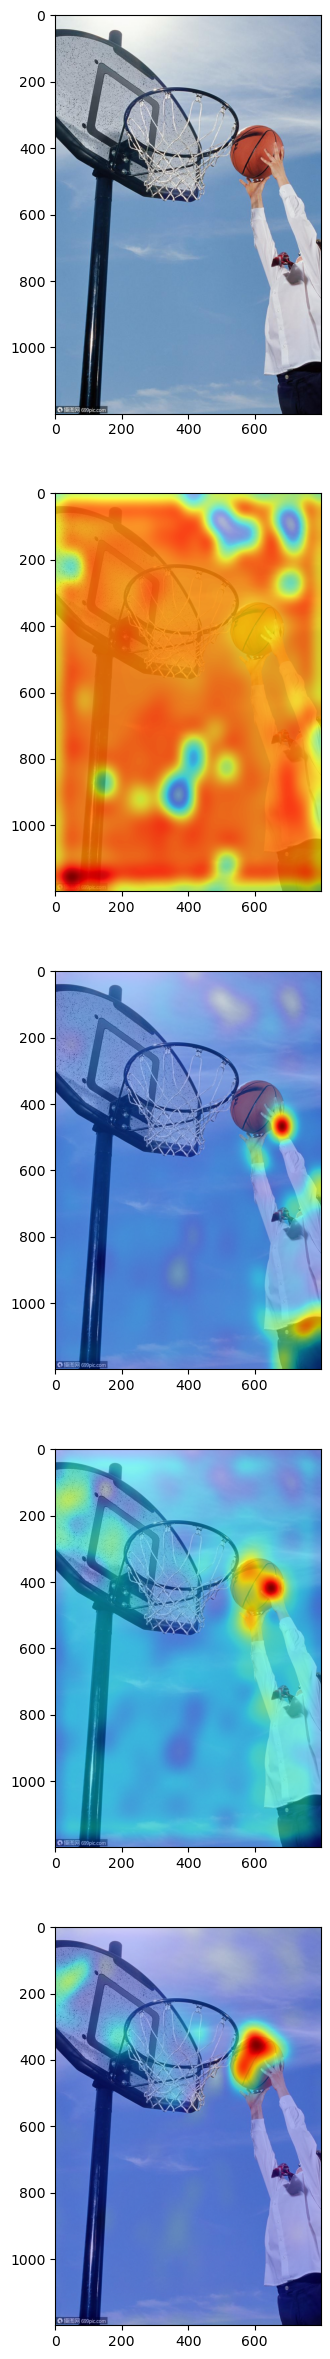

In [188]:
num_image = len(question_input.input_ids[0]) 
rgb_image = cv2.imread('./imgs/basketball.jpg')[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255
print(gradcam.dtype)
fig, ax = plt.subplots(num_image, 1, figsize=(15,30))
ax[0].imshow(rgb_image)
for i,token_id in enumerate(question_input.input_ids[0][1:]):
    word = tokenizer.decode([token_id])
    gradcam_image = getAttMap(rgb_image, gradcam[i+1])
    ax[i+1].imshow(gradcam_image)




In [9]:
for  topk_id, topk_prob in zip(topk_ids, topk_probs):         
            _, pred = topk_prob.max(dim=0)
            print( "answer:"+answer_list[topk_id[pred]])

answer:basketball[SEP]
